# Predicting rain in Seattle

In [55]:
# Import packages for data exploration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar

sns.set(context='notebook', style='whitegrid', font_scale=2, rc={'figure.figsize': (20, 10)})

## About the dataset

In [56]:
# Read in Seattle weather file

seattle = pd.read_csv('seattleWeather_1948-2017.csv')
seattle.head()

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


In [57]:
seattle.tail()

,DATE,PRCP,TMAX,TMIN,RAIN
25546,2017-12-10,0.0,49,34,False
25547,2017-12-11,0.0,49,29,False
25548,2017-12-12,0.0,46,32,False
25549,2017-12-13,0.0,48,34,False
25550,2017-12-14,0.0,50,36,False


In [58]:
# View dataset info

seattle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25551 entries, 0 to 25550
Data columns (total 5 columns):
DATE    25551 non-null object
PRCP    25548 non-null float64
TMAX    25551 non-null int64
TMIN    25551 non-null int64
RAIN    25548 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 998.2+ KB


In [59]:
# Count NaN values in dataset

seattle.isnull().sum()

DATE    0
PRCP    3
TMAX    0
TMIN    0
RAIN    3
dtype: int64

In [60]:
# Describe Seattle dataset summary statistics

seattle.describe()

,PRCP,TMAX,TMIN
count,25548.000000,25551.000000,25551.000000
mean,0.106222,59.544206,44.514226
std,0.239031,12.772984,8.892836
min,0.000000,4.000000,0.000000
25%,0.000000,50.000000,38.000000
50%,0.000000,58.000000,45.000000
75%,0.100000,69.000000,52.000000
max,5.020000,103.000000,71.000000


It appears that `seattleWeather_1948-2017.csv` contains information about the weather in the city of Seattle from 1948 to 2017. The dataset contains the following columns:

- `DATE` -- The date the weather data was collected, in YYYY-MM-DD format
- `PRCP` -- Precipiation in inches
- `TMIN` -- Minimum temperature in Farenheit
- `TMAX` -- Maximum temperature in Farenheit

There also appears to be 3 `NaN` values each in `PRCP` and `RAIN`. 

## Cleaning up Seattle weather dataset

Checklist:

- Check that `RAIN` labels are correct:
 - Is `PRCP` 0 when `RAIN` is `False`?
 - Is `PRCP` greater than 0 when `RAIN` is `True`?
- Convert `DATE` to `datetime` format and `RAIN` to `bool` (then `int` after handling `NaN` values)
- Decide what to do with `NaN` values
- Split `DATE` to `YEAR`, `MONTH` and `DAY` numericals since `sklearn` likely isn't able to handle `datetime`
- Check that `TMIN` is always less then `TMAX`

In [61]:
# Are RAIN labels correct? Check that PRCP is actually 0 when RAIN is False

seattle['PRCP'].loc[seattle['RAIN'] == False].sum()

0.0

In [62]:
# Check values for RAIN when PRCP > 0

seattle['RAIN'].loc[seattle['PRCP'] > 0].value_counts()

True    10900
Name: RAIN, dtype: int64

From the results of the above two cells, it seems the `RAIN` column does not need to be corrected.   

In [63]:
# Convert DATE column to datetime format

seattle['DATE'] = pd.to_datetime(seattle['DATE'], format="%Y-%m-%d")
seattle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25551 entries, 0 to 25550
Data columns (total 5 columns):
DATE    25551 non-null datetime64[ns]
PRCP    25548 non-null float64
TMAX    25551 non-null int64
TMIN    25551 non-null int64
RAIN    25548 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 998.2+ KB


In [64]:
seattle.head()

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


In [65]:
# Check out NaN values
seattle.loc[(seattle['PRCP'].isnull()) | (seattle['TMIN'].isnull())]

,DATE,PRCP,TMAX,TMIN,RAIN
18415,1998-06-02,NaN,72,52,NaN
18416,1998-06-03,NaN,66,51,NaN
21067,2005-09-05,NaN,70,52,NaN


All 3 `NaN` values for `RAIN` co-occur with the 3 `NaN` values for `PRCP`. It seems best to simply remove all `NaN` values from the dataset rather than imputing `PRCP` values from the same day of the year, which means there will be 25548 rows remaining. 

In [66]:
# Remove NaN values from dataset

seattle_nonull = seattle.dropna()
seattle_nonull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25548 entries, 0 to 25550
Data columns (total 5 columns):
DATE    25548 non-null datetime64[ns]
PRCP    25548 non-null float64
TMAX    25548 non-null int64
TMIN    25548 non-null int64
RAIN    25548 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 1.2+ MB


In [67]:
# Convert RAIN to boolean, then int

seattle_nonull['RAIN'] = seattle_nonull['RAIN'].astype('bool').astype('int')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [68]:
# Check for TMIN values that are more than TMAX

seattle_nonull.loc[seattle_nonull['TMIN'] > seattle_nonull['TMAX']] 

,DATE,PRCP,TMAX,TMIN,RAIN
1419,1951-11-20,0.08,4,39,1


In [69]:
# Remove row by inverse selection

seattle_nonull = seattle_nonull.loc[~(seattle_nonull['TMIN'] > seattle_nonull['TMAX'])] 

In [70]:
# Check that row 1419 has been removed

seattle_nonull.loc[1418:1421, ]

,DATE,PRCP,TMAX,TMIN,RAIN
1418,1951-11-19,0.06,53,40,1
1420,1951-11-21,0.00,46,33,0
1421,1951-11-22,0.00,43,29,0


## Plotting precipitation and temperature in Seattle 1949-2017 

In [71]:
# Set index as DATE

seattle_indexed = seattle_nonull.set_index('DATE')

In [72]:
# Define function to categorise dates into seasons

def apply_season(date):
    if date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    elif date.month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

In [73]:
# Map date to season

seattle_indexed['SEASON'] = seattle_indexed.index.map(apply_season)

# Format SEASON as category in chronological order

seattle_indexed['SEASON'] = pd.Categorical(seattle_indexed['SEASON'],
                                           ['Winter', 'Spring', 'Summer', 'Autumn'])

# Check values of SEASON column

seattle_indexed['SEASON'].value_counts()

Spring    6440
Summer    6438
Autumn    6368
Winter    6301
Name: SEASON, dtype: int64

In [74]:
# Extract month name from index

seattle_indexed['MONTH NAME'] = seattle_indexed.index.map(lambda x: calendar.month_name[x.month])

# Format MONTH NAME column as category with months in chronological order

seattle_indexed['MONTH NAME'] = pd.Categorical(seattle_indexed['MONTH NAME'],
                                          ['January', 'February', 'March',
                                           'April', 'May', 'June', 'July',
                                           'August', 'September', 'October',
                                           'November', 'December'])

# Check values of MONTH NAME

seattle_indexed['MONTH NAME'].value_counts()

October      2170
August       2170
July         2170
May          2170
March        2170
January      2170
December     2153
April        2100
November     2099
September    2099
June         2098
February     1978
Name: MONTH NAME, dtype: int64

In [75]:
# Extract year, month and day from index to create YEAR, MONTH and DAY numerical column

seattle_indexed['YEAR'] = seattle_indexed.index.map(lambda x: x.year)
seattle_indexed['MONTH'] = seattle_indexed.index.map(lambda x: x.month)
seattle_indexed['DAY'] = seattle_indexed.index.map(lambda x: x.day)
seattle_indexed = seattle_indexed[['YEAR', 'MONTH', 'DAY', 'MONTH NAME', 'SEASON', 'TMIN', 'TMAX', 'PRCP', 'RAIN']]
seattle_indexed.head()

,YEAR,MONTH,DAY,MONTH NAME,SEASON,TMIN,TMAX,PRCP,RAIN
DATE,,,,,,,,,
1948-01-01,1948,1,1,January,Winter,42,51,0.47,1
1948-01-02,1948,1,2,January,Winter,36,45,0.59,1
1948-01-03,1948,1,3,January,Winter,35,45,0.42,1
1948-01-04,1948,1,4,January,Winter,34,45,0.31,1
1948-01-05,1948,1,5,January,Winter,32,45,0.17,1


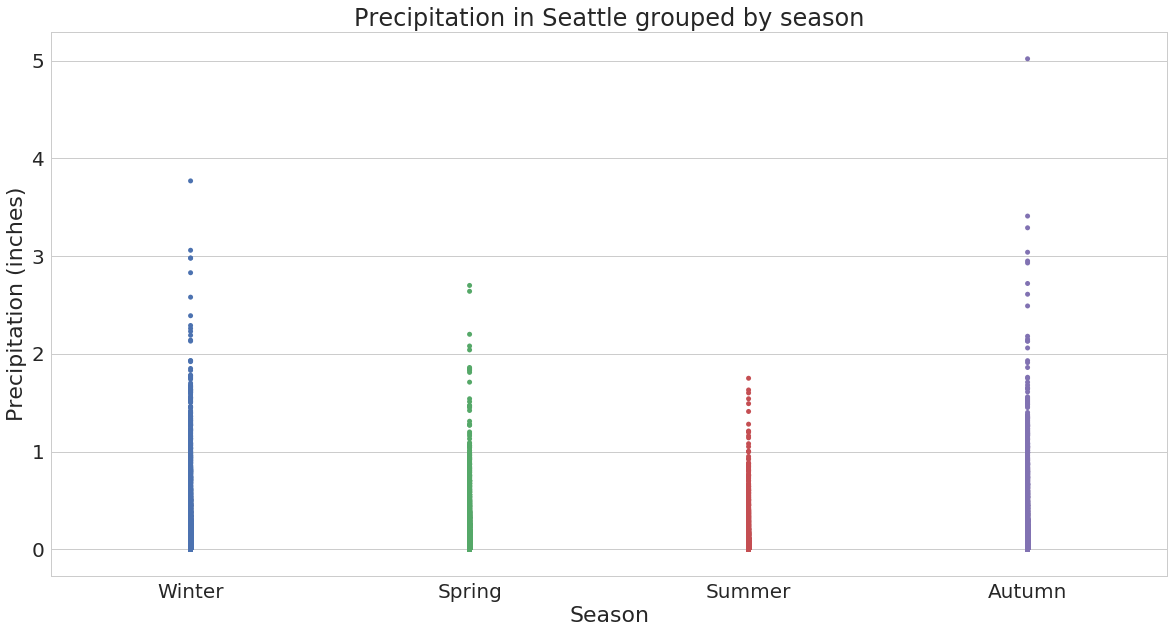

In [76]:
# Draw boxplot for precipitation against season

sns.stripplot(data=seattle_indexed, x='SEASON', y='PRCP')
plt.xlabel('Season')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation in Seattle grouped by season')
plt.show()

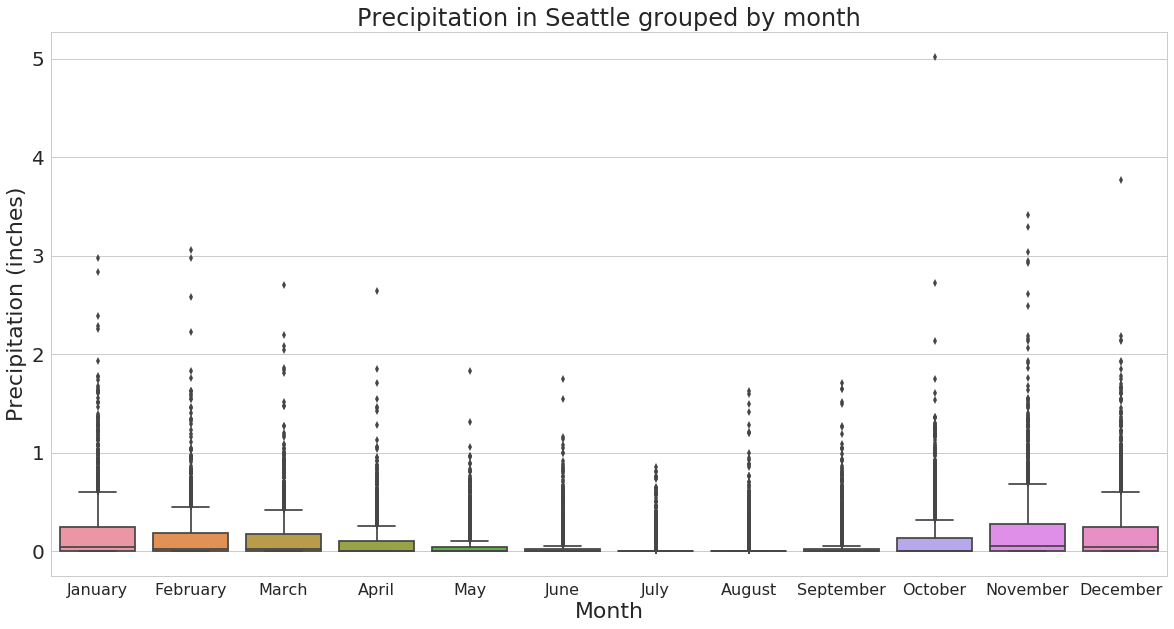

In [77]:
# Draw boxplot of precipitation according to month

sns.boxplot(data=seattle_indexed, x='MONTH NAME', y='PRCP')
plt.xlabel('Month')
plt.xticks(fontsize=16)
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation in Seattle grouped by month')
plt.show()

In [78]:
# Plot rainy days by month

rain_month_count = seattle_indexed.groupby('MONTH NAME')['RAIN'].sum().reset_index()
rain_month_count = pd.merge(rain_month_count,  seattle_indexed['MONTH NAME'].value_counts().reset_index(),
                            left_on='MONTH NAME', right_on='index')
del rain_month_count['index']
rain_month_count = rain_month_count.rename(columns={'MONTH NAME_x': 'MONTH NAME', 'MONTH NAME_y': 'TOTAL DAYS'}) 
rain_month_count['NO RAIN'] = rain_month_count['TOTAL DAYS'] - rain_month_count['RAIN']
rain_month_count.set_index('MONTH NAME', inplace=True)

rain_month_count.head()

,RAIN,TOTAL DAYS,NO RAIN
MONTH NAME,,,
January,1298,2170,872
February,1103,1978,875
March,1212,2170,958
April,998,2100,1102
May,771,2170,1399


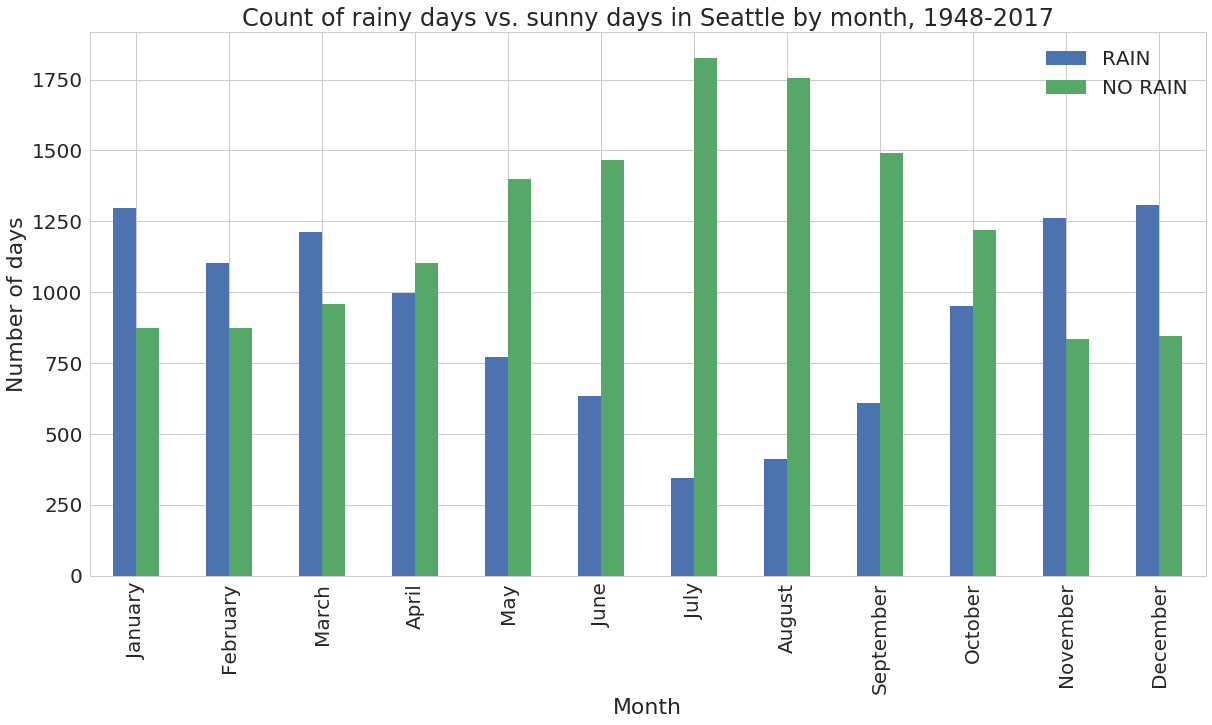

In [79]:
# Plot count of rain vs no rain per month

rain_month_count[['RAIN', 'NO RAIN']].plot(kind='bar')
plt.ylabel('Number of days')
plt.xlabel('Month')
plt.title('Count of rainy days vs. sunny days in Seattle by month, 1948-2017')
plt.show()

In [80]:
# Count number of rainy days vs sunny days every month-year pair

rain_month_year_count = seattle_indexed.groupby(['YEAR', 'MONTH NAME'])\
                        ['RAIN', 'TMAX'].agg({'RAIN': 'sum', 'TMAX': 'count'}).\
                        reset_index().rename(columns={'TMAX': 'TOTAL DAYS'})
        
rain_month_year_count['NO RAIN'] = rain_month_year_count['TOTAL DAYS'] - rain_month_year_count['RAIN'] 
rain_month_year_count.head()

,YEAR,MONTH NAME,RAIN,TOTAL DAYS,NO RAIN
0,1948,January,16,31,15
1,1948,February,16,29,13
2,1948,March,14,31,17
3,1948,April,20,30,10
4,1948,May,16,31,15


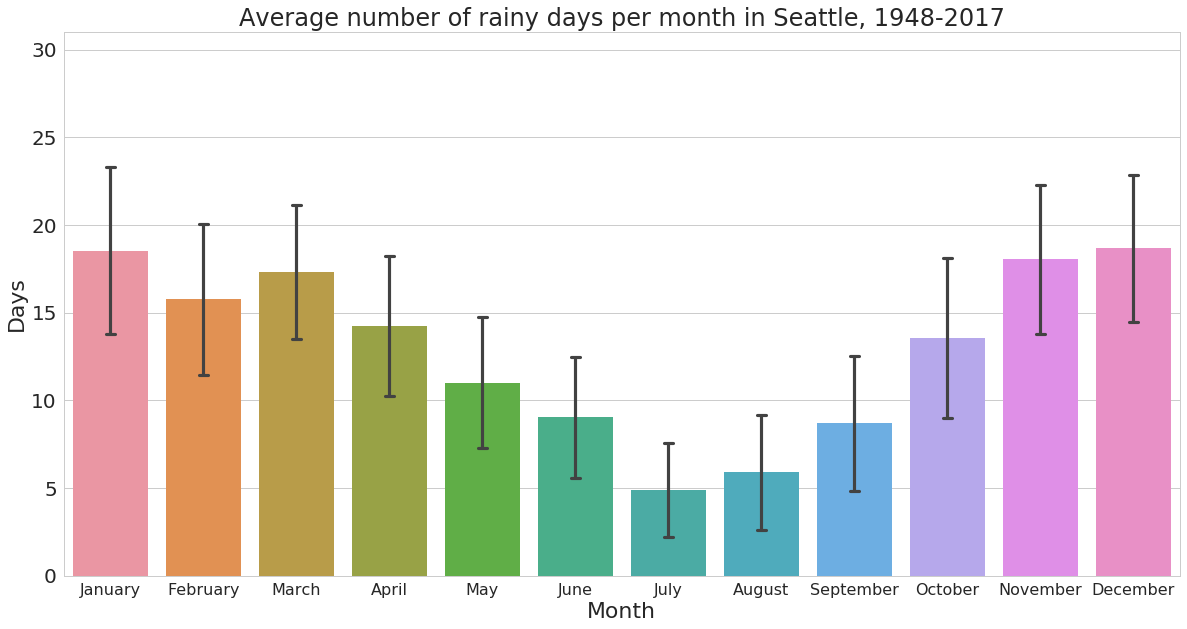

In [81]:
# Plot average number of rainy days per month

sns.barplot(data=rain_month_year_count, x='MONTH NAME', y='RAIN', ci='sd', capsize=0.1)
plt.ylabel('Days')
plt.ylim(0, 31)
plt.xlabel('Month')
plt.xticks(fontsize=16)
plt.title('Average number of rainy days per month in Seattle, 1948-2017')
plt.show()

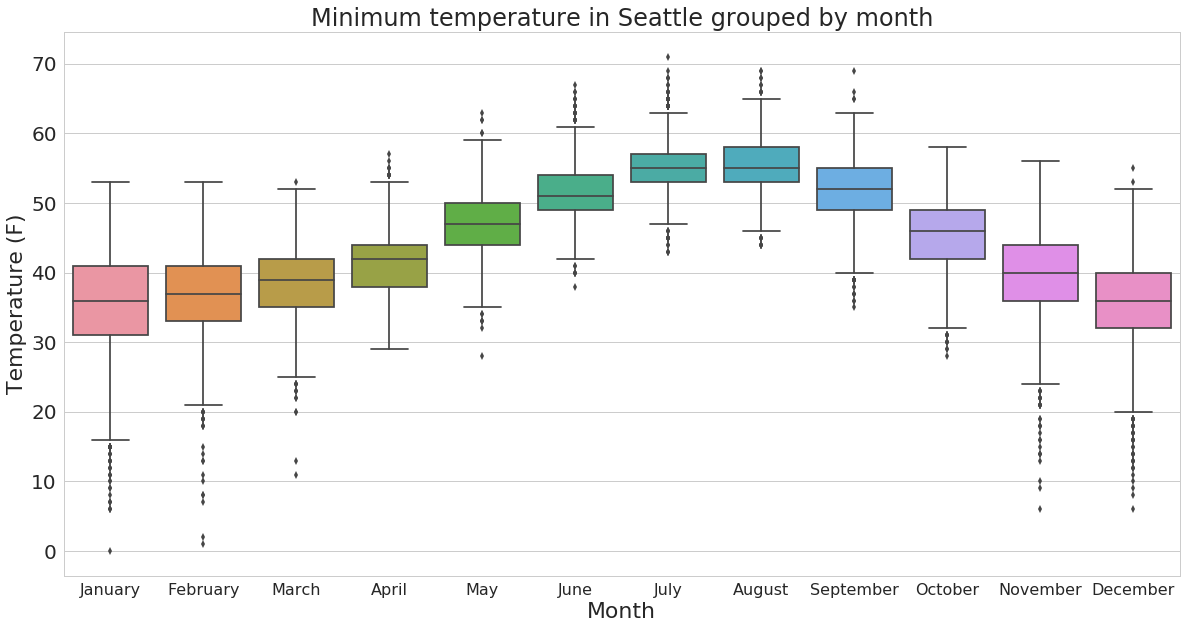

In [82]:
# Plot TMIN by month

sns.boxplot(data=seattle_indexed, x='MONTH NAME', y='TMIN')
plt.xlabel('Month')
plt.xticks(fontsize=16)
plt.ylabel('Temperature (F)')
plt.title('Minimum temperature in Seattle grouped by month')
plt.show()

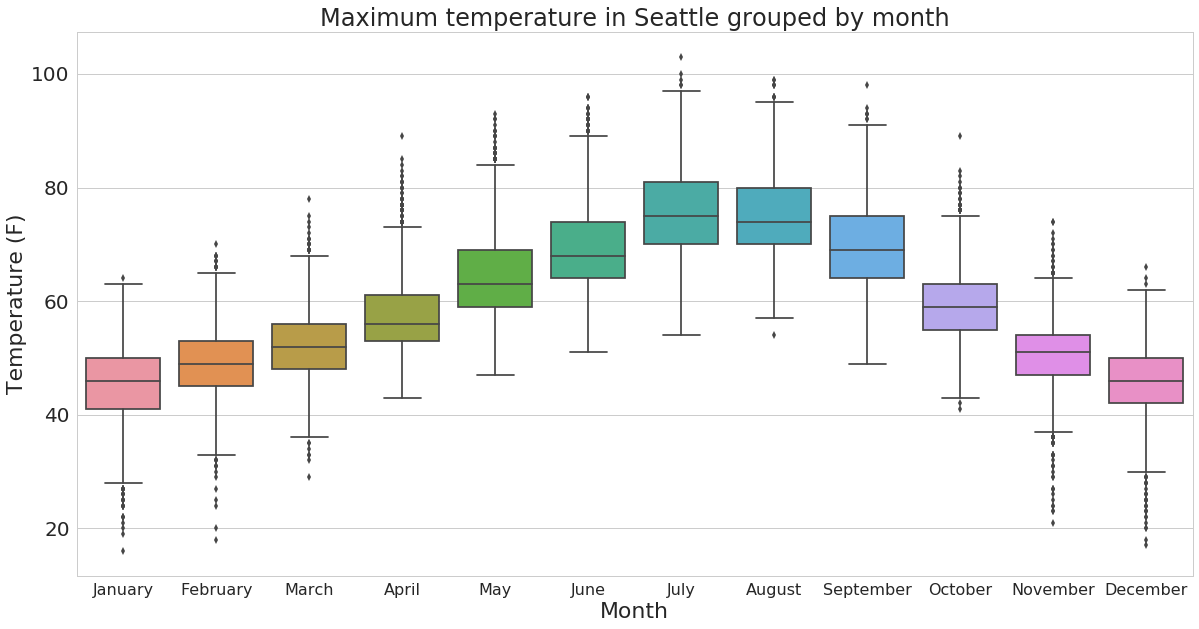

In [83]:
# Plot TMAX by month

sns.boxplot(data=seattle_indexed, x='MONTH NAME', y='TMAX')
plt.xlabel('Month')
plt.xticks(fontsize=16)
plt.ylabel('Temperature (F)')
plt.title('Maximum temperature in Seattle grouped by month')
plt.show()

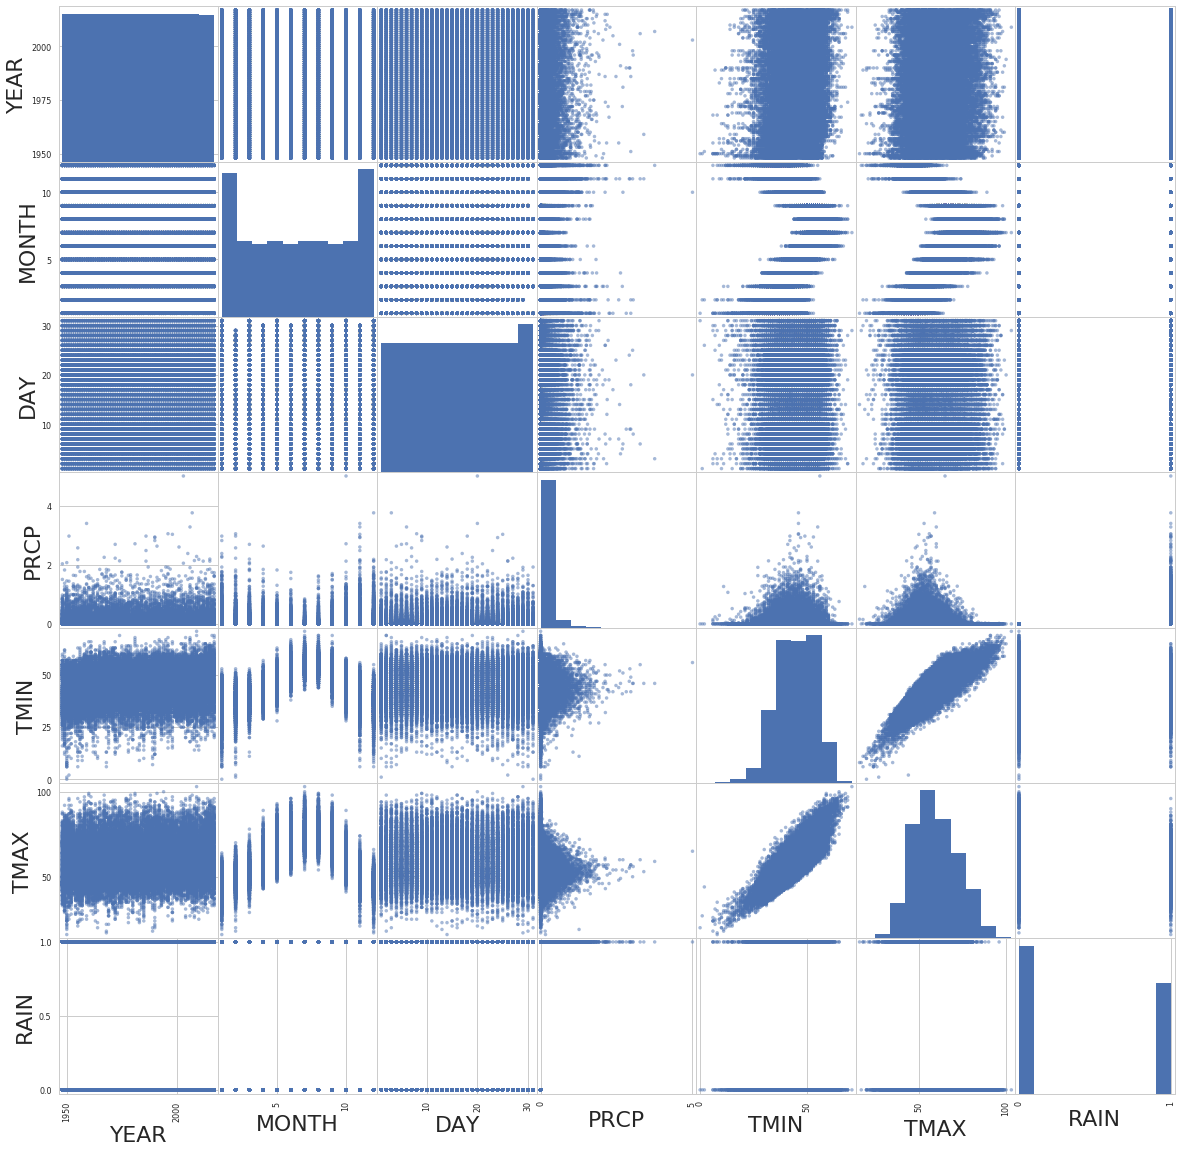

In [84]:
seattle_scatter = seattle_indexed.loc[:, ['YEAR', 'MONTH', 'DAY', 'PRCP', 'TMIN', 'TMAX', 'RAIN']]

pd.plotting.scatter_matrix(seattle_scatter, figsize=(20, 20))
plt.show()

Generally:

- Daily average `PCRP` is low during the summer months (June, July, August) compared to the rest of the year.
- Consequently, the same period has the least average number of days where `RAIN` is `True`.
- Daily `TMIN` and `TMAX` is higher during the summer and at the lowest during the winter (December, January) 
- `TMIN` and `TMAX` appear to be highly co-linear and one of the two should be excluded as a feature in a logistic regresion model

### Selecting an extra feature

A useful extra feature could be: _Did it rain the previous day?_


In [85]:
# View Seattle dataset again

seattle_indexed = seattle_indexed.reset_index()

seattle_indexed.head(10)

,DATE,YEAR,MONTH,DAY,MONTH NAME,SEASON,TMIN,TMAX,PRCP,RAIN
0,1948-01-01,1948,1,1,January,Winter,42,51,0.47,1
1,1948-01-02,1948,1,2,January,Winter,36,45,0.59,1
2,1948-01-03,1948,1,3,January,Winter,35,45,0.42,1
3,1948-01-04,1948,1,4,January,Winter,34,45,0.31,1
4,1948-01-05,1948,1,5,January,Winter,32,45,0.17,1
5,1948-01-06,1948,1,6,January,Winter,39,48,0.44,1
6,1948-01-07,1948,1,7,January,Winter,40,50,0.41,1
7,1948-01-08,1948,1,8,January,Winter,35,48,0.04,1
8,1948-01-09,1948,1,9,January,Winter,31,50,0.12,1
9,1948-01-10,1948,1,10,January,Winter,34,43,0.74,1


In [86]:
# Initialise WEEKLY_PRCP_AVG as NaNs

seattle_indexed['WEEKLY_PRCP_AVG'] = np.nan

# Set RAIN_YESTERDAY as previous row value for RAIN

for i in range(7, len(seattle_indexed)):
    seattle_indexed.loc[i, 'WEEKLY_PRCP_AVG'] = seattle_indexed.loc[i-7:i-1, 'PRCP'].mean()

# Check new dataframe    
    
seattle_indexed.head(15)   

,DATE,YEAR,MONTH,DAY,MONTH NAME,SEASON,TMIN,TMAX,PRCP,RAIN,WEEKLY_PRCP_AVG
0,1948-01-01,1948,1,1,January,Winter,42,51,0.47,1,NaN
1,1948-01-02,1948,1,2,January,Winter,36,45,0.59,1,NaN
2,1948-01-03,1948,1,3,January,Winter,35,45,0.42,1,NaN
3,1948-01-04,1948,1,4,January,Winter,34,45,0.31,1,NaN
4,1948-01-05,1948,1,5,January,Winter,32,45,0.17,1,NaN
5,1948-01-06,1948,1,6,January,Winter,39,48,0.44,1,NaN
6,1948-01-07,1948,1,7,January,Winter,40,50,0.41,1,NaN
7,1948-01-08,1948,1,8,January,Winter,35,48,0.04,1,0.401429
8,1948-01-09,1948,1,9,January,Winter,31,50,0.12,1,0.340000
9,1948-01-10,1948,1,10,January,Winter,34,43,0.74,1,0.272857


In [87]:
# Initialise RAIN_YESTERDAY as NaNs

seattle_indexed['RAIN_YESTERDAY'] = np.nan

# Set RAIN_YESTERDAY as previous row value for RAIN

for i in range(1, len(seattle_indexed)):
    seattle_indexed.loc[i, 'RAIN_YESTERDAY'] = seattle_indexed.loc[i-1, 'RAIN']

# Check new dataframe    
    
seattle_indexed.head(15)    

,DATE,YEAR,MONTH,DAY,MONTH NAME,SEASON,TMIN,TMAX,PRCP,RAIN,WEEKLY_PRCP_AVG,RAIN_YESTERDAY
0,1948-01-01,1948,1,1,January,Winter,42,51,0.47,1,NaN,NaN
1,1948-01-02,1948,1,2,January,Winter,36,45,0.59,1,NaN,1.0
2,1948-01-03,1948,1,3,January,Winter,35,45,0.42,1,NaN,1.0
3,1948-01-04,1948,1,4,January,Winter,34,45,0.31,1,NaN,1.0
4,1948-01-05,1948,1,5,January,Winter,32,45,0.17,1,NaN,1.0
5,1948-01-06,1948,1,6,January,Winter,39,48,0.44,1,NaN,1.0
6,1948-01-07,1948,1,7,January,Winter,40,50,0.41,1,NaN,1.0
7,1948-01-08,1948,1,8,January,Winter,35,48,0.04,1,0.401429,1.0
8,1948-01-09,1948,1,9,January,Winter,31,50,0.12,1,0.340000,1.0
9,1948-01-10,1948,1,10,January,Winter,34,43,0.74,1,0.272857,1.0


## Logistic regression model for predicting rain in Seattle

In [88]:
import itertools

from sklearn import model_selection
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets, metrics
from sklearn.dummy import DummyClassifier

In [89]:
# Define function for confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [90]:
# Split dataset into training/test and holdout

seattle_training = seattle_indexed.loc[(seattle_indexed['YEAR'] >= 1950) & 
                                       (seattle_indexed['YEAR'] <= 2009)]

seattle_val = seattle_indexed.loc[seattle_indexed['YEAR'] >= 2010]

# Convert RAIN YESTERDAY column from float to int

seattle_training['RAIN_YESTERDAY'] = seattle_training['RAIN_YESTERDAY'].astype('int')
seattle_val['RAIN_YESTERDAY'] = seattle_val['RAIN_YESTERDAY'].astype('int')

# View seattle_training

seattle_training.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,DATE,YEAR,MONTH,DAY,MONTH NAME,SEASON,TMIN,TMAX,PRCP,RAIN,WEEKLY_PRCP_AVG,RAIN_YESTERDAY
731,1950-01-01,1950,1,1,January,Winter,24,32,0.25,1,0.342857,1
732,1950-01-02,1950,1,2,January,Winter,6,24,0.01,1,0.345714,1
733,1950-01-03,1950,1,3,January,Winter,6,26,0.10,1,0.330000,1
734,1950-01-04,1950,1,4,January,Winter,14,28,0.00,0,0.162857,1
735,1950-01-05,1950,1,5,January,Winter,22,38,0.08,1,0.125714,0


In [91]:
seattle_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21911 entries, 731 to 22641
Data columns (total 12 columns):
DATE               21911 non-null datetime64[ns]
YEAR               21911 non-null int64
MONTH              21911 non-null int64
DAY                21911 non-null int64
MONTH NAME         21911 non-null category
SEASON             21911 non-null category
TMIN               21911 non-null int64
TMAX               21911 non-null int64
PRCP               21911 non-null float64
RAIN               21911 non-null int64
WEEKLY_PRCP_AVG    21911 non-null float64
RAIN_YESTERDAY     21911 non-null int64
dtypes: category(2), datetime64[ns](1), float64(2), int64(7)
memory usage: 1.9 MB


### Test `PRCP` only

Accuracy score should be 1, as `PRCP` being more than 0 determines whether `RAIN` is `True`/`1`. 

In [92]:
# Choose variables

feature_cols = ['PRCP']

X = seattle_training[feature_cols]
y = seattle_training.RAIN

# Split variables

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=1)

# Fit logistic regression model

logreg_cv = LogisticRegressionCV()
logreg_cv.fit(X_train, y_train)

# Predict with test data

y_pred_class = logreg_cv.predict(X_test)
print (metrics.accuracy_score(y_test, y_pred_class))

1.0


Confusion matrix, without normalization
[[2315    0]
 [   0 3163]]


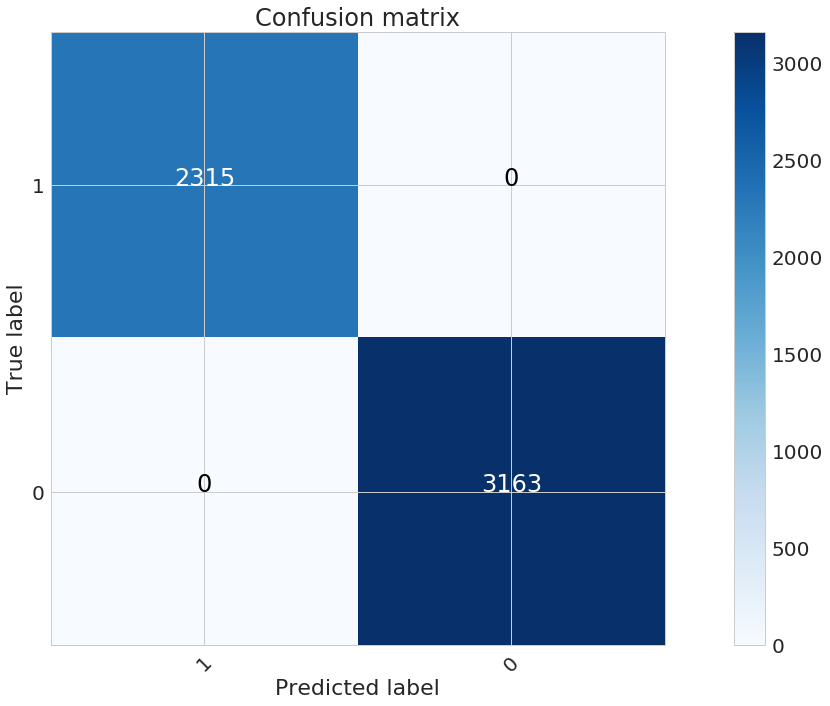

In [93]:
# plot an attractive confusion matrix
cnf_mat = metrics.confusion_matrix(y_test, y_pred_class, labels = seattle_training.RAIN.unique())
class_labels = seattle_training.RAIN.unique()
plt.figure()
plot_confusion_matrix(cnf_mat, class_labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plt.show()

### Model without `PRCP`

If a model is to be used for predicting rain in the future, `PRCP` will have to be excluded as a feature, since a record of future precipitation will not be available.

In [94]:
# Choose variables

feature_cols = ['YEAR', 'MONTH', 'DAY', 'TMIN', 'RAIN_YESTERDAY']

X = seattle_training[feature_cols]
y = seattle_training.RAIN

X_val = seattle_val[feature_cols]
y_val = seattle_val.RAIN

# Split variables

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=1)

In [95]:
# Calculate null accuracy

dumb = DummyClassifier(strategy='most_frequent')
dumb.fit(X_train, y_train)
y_dumb_class = dumb.predict(X_test)
print ('Null accuracy is', metrics.accuracy_score(y_test, y_dumb_class))

Null accuracy is 0.5774005111354509


In [96]:
# Fit logistic regression model with KFold validation where K = 10

logreg_cv = LogisticRegressionCV(cv=model_selection.KFold(20, shuffle=True, random_state=1), max_iter=100)
logreg_cv.fit(X_train, y_train)

# Predict with test data

y_pred_class = logreg_cv.predict(X_test)
print ('Accuracy of model (prediction with X_test)', metrics.accuracy_score(y_test, y_pred_class))

# Predict with holdout data

y_val_class = logreg_cv.predict(X_val)
print ('Accuracy of model (prediction with X_val)', metrics.accuracy_score(y_val, y_val_class))

Accuracy of model (prediction with X_test) 0.7077400511135451
Accuracy of model (prediction with X_val) 0.7201376936316696


In [97]:
# Print co-efficients and intercept

print('Coefficients:', list(zip(feature_cols, logreg_cv.coef_[0])))
print('Intercept:', logreg_cv.intercept_)

Coefficients: [('YEAR', -1.3077367824288965e-05), ('MONTH', -0.011750056296359515), ('DAY', -0.001798575812706489), ('TMIN', -0.01824561678312039), ('RAIN_YESTERDAY', 1.4110443336500775)]
Intercept: [0.00125716]


In [98]:
# Compare accuracy to model using 20-fold cross-validation
scores = model_selection.cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=20)
print (scores)
print ('Mean of 20-fold cross validation:', scores.mean())

[0.73108478 0.69279854 0.71649954 0.72354015 0.69434307 0.69251825
 0.69981752 0.71806569 0.71598174 0.68401826 0.69680365 0.71141553
 0.71780822 0.71324201 0.73607306 0.71232877 0.7086758  0.70958904
 0.73515982 0.69954338]
Mean of 20-fold cross validation: 0.7104653401645555


Confusion matrix, without normalization
[[1518  797]
 [ 804 2359]]


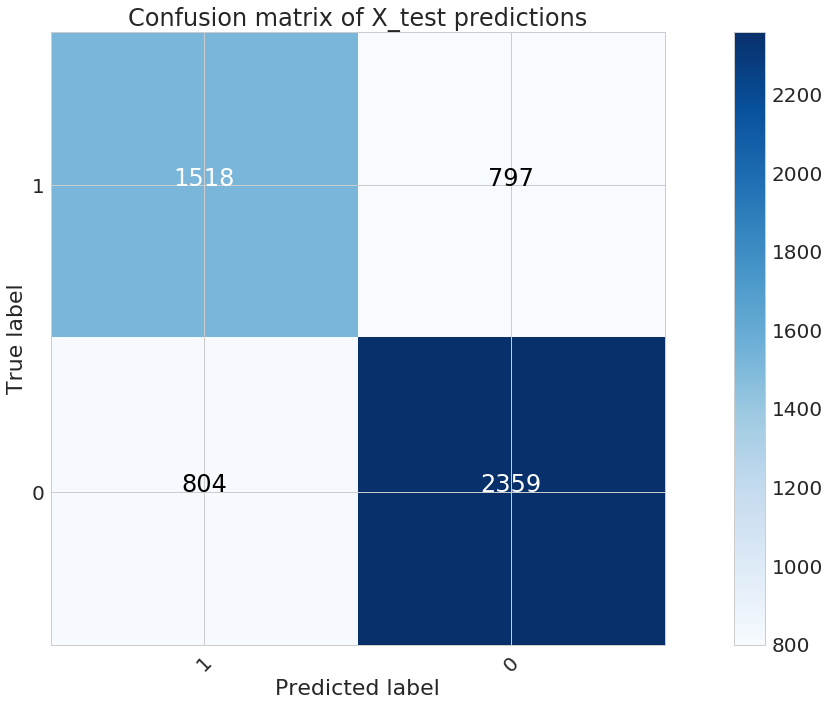

In [99]:
# Plot confusion matrix
cnf_mat = metrics.confusion_matrix(y_test, y_pred_class, labels = seattle_training.RAIN.unique())
class_labels = seattle_training.RAIN.unique()
plt.figure()
plot_confusion_matrix(cnf_mat, class_labels,
                          normalize=False,
                          title='Confusion matrix of X_test predictions',
                          cmap=plt.cm.Blues)
plt.show()

Confusion matrix, without normalization
[[ 894  406]
 [ 407 1198]]


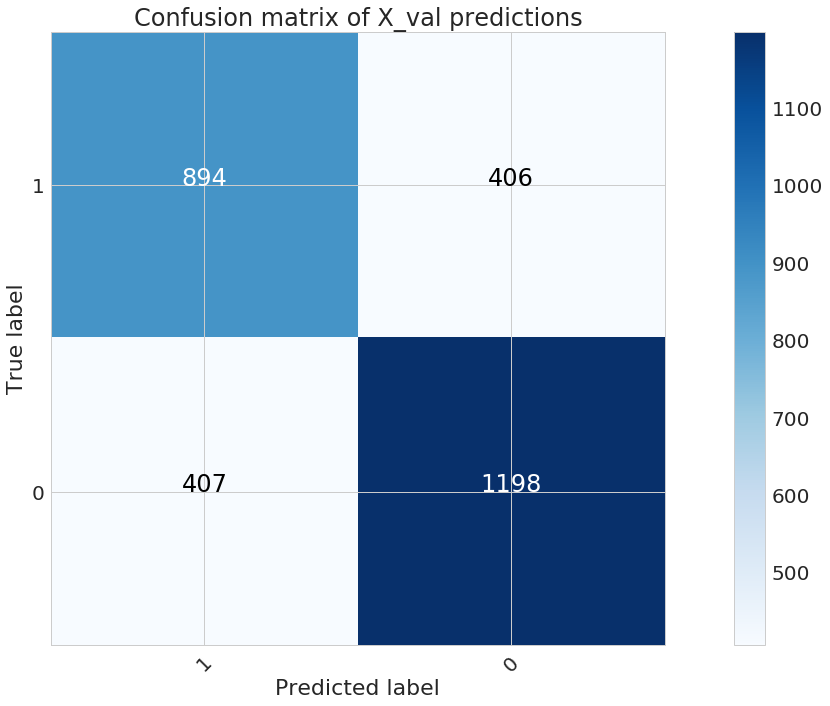

In [100]:
# Plot confusion matrix with holdout data
cnf_mat = metrics.confusion_matrix(y_val, y_val_class, labels = seattle_training.RAIN.unique())
class_labels = seattle_training.RAIN.unique()
plt.figure()
plot_confusion_matrix(cnf_mat, class_labels,
                          normalize=False,
                          title='Confusion matrix of X_val predictions',
                          cmap=plt.cm.Blues)
plt.show()

In [101]:
# Calculate TPR and TNR

print('---- TRAINING & TEST ----')
print('True positive rate is', 1518/(1518+797))
print('True negative rate is', 2359/(2359+804))
print('---- VALIDATION ----')
print('True positive rate is', 894/(894+406))
print('True negative rate is', 1198/(1198+407))

---- TRAINING & TEST ----
True positive rate is 0.6557235421166306
True negative rate is 0.7458109389819791
---- VALIDATION ----
True positive rate is 0.6876923076923077
True negative rate is 0.746417445482866


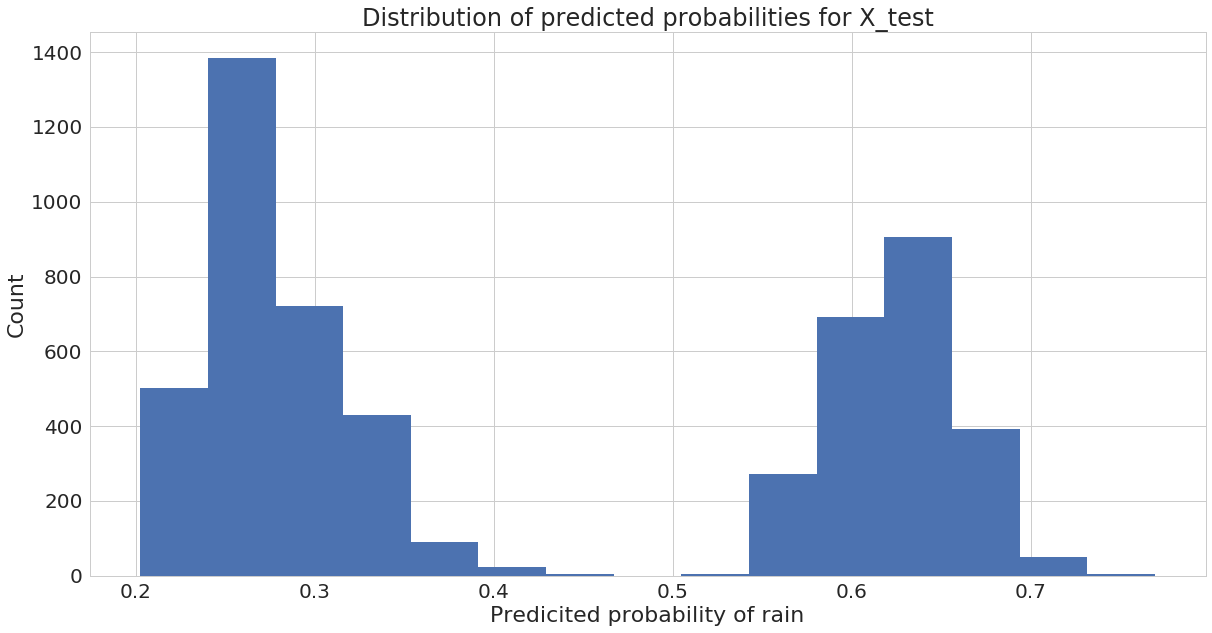

In [102]:
# Generate the prediction values for each of the test observations 
preds = logreg_cv.predict_proba(X_test)[:,1]

plt.hist(preds, bins=15)
plt.title('Distribution of predicted probabilities for X_test')
plt.xlabel('Predicited probability of rain')
plt.ylabel('Count')
plt.show()

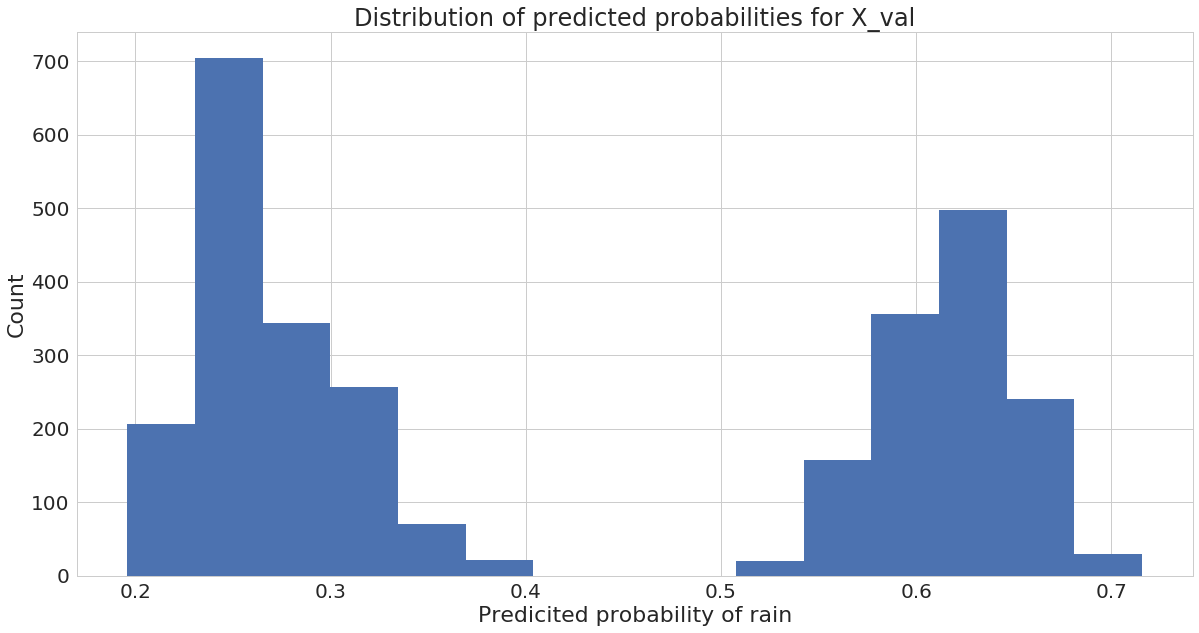

In [103]:
# Generate the prediction values for each of the holdout observations 
preds = logreg_cv.predict_proba(X_val)[:,1]

plt.hist(preds, bins=15)
plt.title('Distribution of predicted probabilities for X_val')
plt.xlabel('Predicited probability of rain')
plt.ylabel('Count')
plt.show()

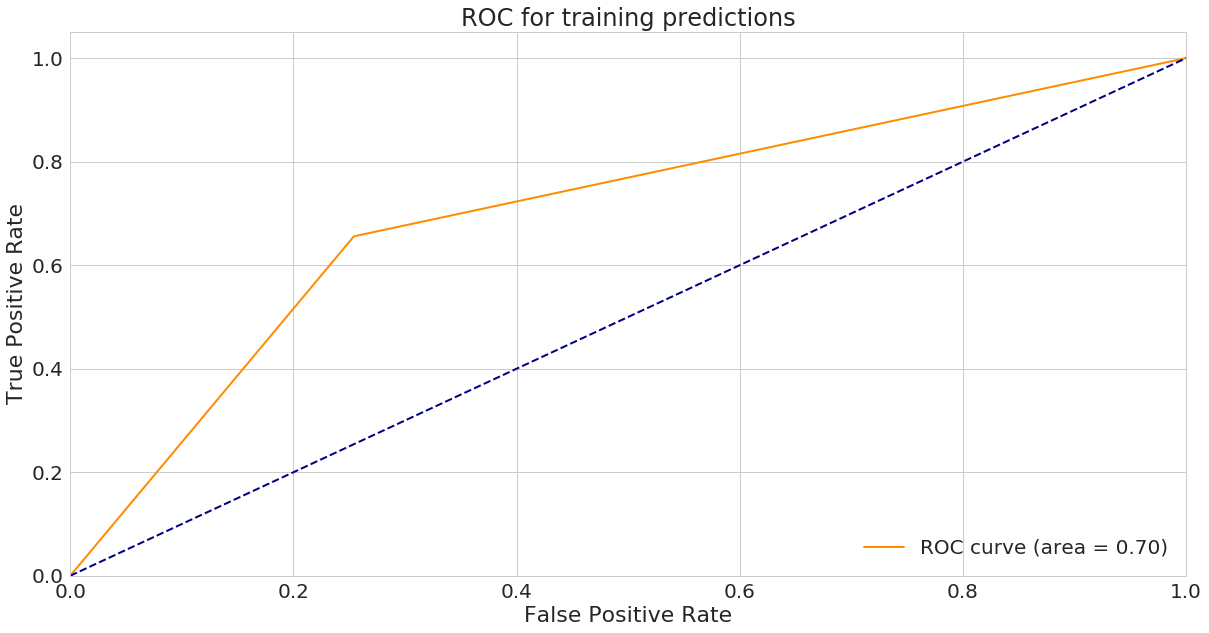

In [104]:
# get FPR and TPR for test data
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_class)

# Store the Area Under the Curve (AUC)
roc_auc = metrics.auc(fpr,tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for training predictions')
plt.legend(loc="lower right")
plt.show()

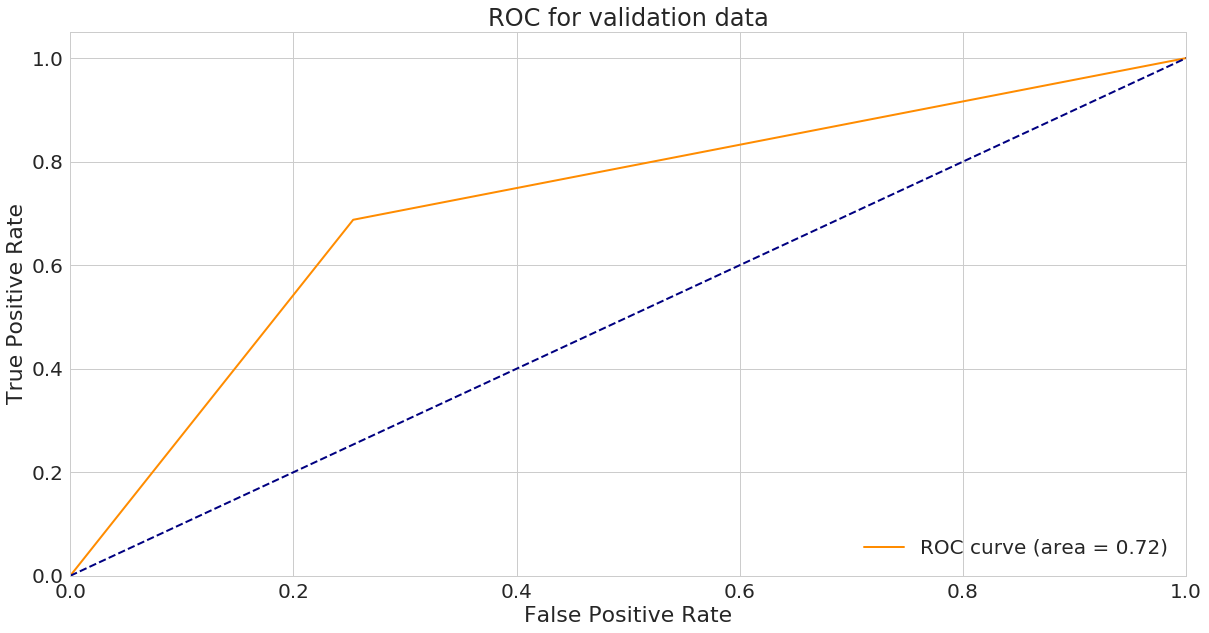

In [105]:
# get FPR and TPR for holdout data
fpr, tpr, _ = metrics.roc_curve(y_val, y_val_class)

# Store the Area Under the Curve (AUC)
roc_auc = metrics.auc(fpr,tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for validation data')
plt.legend(loc="lower right")
plt.show()